In [139]:
# We did an easy function last time, let's now do something spicier

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  #For 3d plotting
from matplotlib.pylab import cm
import numpy as np
import random as rand

from midiutil import MIDIFile

%matplotlib inline

X:  [-10.    -9.95  -9.9   -9.85  -9.8 ]
Y:  [-10. -10. -10. -10. -10.]
Z:  [0.07070981 0.07085505 0.07091242 0.07088209 0.07076433]
DataLength: 400


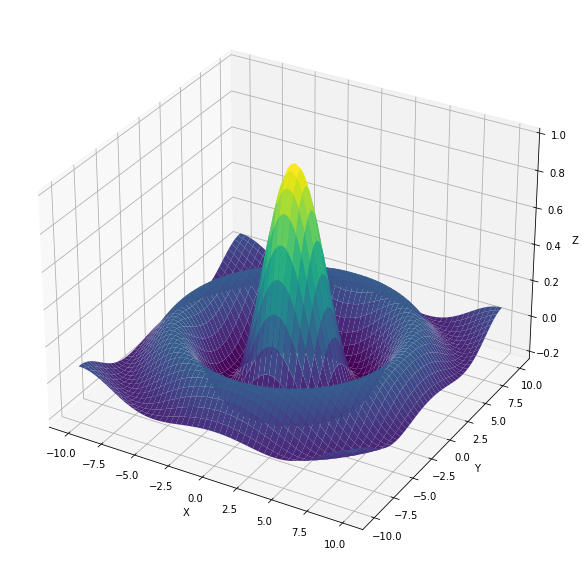

In [140]:
# Funky Surface

def f1(x, y):
    return np.sin(np.sqrt(x**2 + y**2))/np.sqrt(x**2 + y**2)

x = y = np.arange(-10.0, 10.0, 0.05) #range -3 to 3 by steps of 0.05
X, Y = np.meshgrid(x, y) #Makes a Meshgrid
zs = np.array(f1(X, Y)) 
Z = zs.reshape(X.shape)

fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(projection='3d')

ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

print('X: ', X[0][0:5])
print('Y: ', Y[0][0:5])
print('Z: ', Z[0][0:5])

#Isn't she beautiful?
datalen = len(X[0])
print('DataLength:', datalen)

Text(0.5, 0, 'Z Axis')

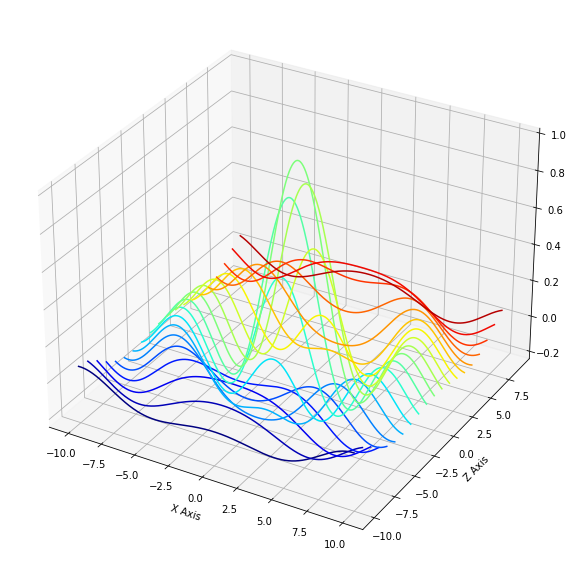

In [141]:
#This time regardless if we slice X or Y we get the same curves as this is Radially Symmetrical
# I think the most interesting part of this data is the slices we do get. Let's look at them
zslice = np.zeros((datalen, datalen))

for i in range(len(X[0])):
    for j in range(len(X[0])):
        zslice[i][j] = Z[j][i]
    
#fig, ax = plt.subplots(1, figsize=(10,6))
colors = cm.jet(np.linspace(0,1,datalen))

fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(projection='3d')

for i in range(0, datalen, 20):
    ax.plot(X[0], Y[i], zslice[i], color=colors[i])   


ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_ylabel('Z Axis')

In [142]:
#We are going to turn each of these strings into a line of Pitches, who have some parameter modulating with their curve.
# So like all the examples before, lets set up out functions.

def set_midi_notes_for_mode(start_note, octaves, mode):
    #Returns a list of Diatonic Notes in the Mode
    #Returns a 2nd list of Accidental Notes not in the Mode
    
    modes = {
    'ionian':[2,2,1,2,2,2,1],
    'dorian':[2,1,2,2,2,1,2],
    'phrygian':[1,2,2,2,1,2,2],
    'lydian':[2,2,2,1,2,2,1],
    'mixolydian':[2,2,1,2,2,1,2],
    'aeolian':[2,1,2,2,1,2,2],
    'lochrian':[1,2,2,1,2,2,2]
    }
    
    diatonics = []
    accidentals = []
    
    for octave in range(octaves):
        note = start_note + (12*octave) #first octave = 0, 2nd=1, etc
        
        for step in modes[mode]:
            diatonics.append(note)
            note = note + step
    last_note = start_note + (octaves*12) #sets last note
    diatonics.append(last_note) #there must be a better way to do this
    
    for i in range(octaves*12): #in range of all semitones
        note = start_note + i
        
        if note not in diatonics:
            accidentals.append(note)
            
    return diatonics, accidentals

def Map_Data_to_MidiNotes_InMode(data, midilist, target_n):
    #Takes data and forces it upon a list of midi notes
    
    step = int(len(data)/target_n)
    data = data[0::step]
    nout = np.interp(data, (data.min(), data.max()), (0, len(midilist)-1))
    out = np.zeros((2, len(nout))) #Set official out array, data:midi

    for i in range(len(nout)):
        s = int(np.round(nout[i]))
        out[0,i] = data[i]
        out[1,i] = midilist[s]
        
    return out

def alt_basic_diatonic_midifile(bpm, note_duration, midi_data):
    
    track = 0
    channel = 0
    velocity = 100 #Constant for now
    miditime = 0
    
    mymidi = MIDIFile(1, eventtime_is_ticks=True)
    mymidi.addTempo(track, miditime, bpm)
    
    
    #Some calculations to approximate length in seconds
    # qnps = 1/(bpm/60.)*4 #quarter per sec
    spq = 1/(bpm/60.)
    note_time = note_duration / 960.
    tot_notetime = spq*note_time
    print('File Length:', len(midi_data)*(tot_notetime), 'seconds')
    
    for note in range(len(midi_data)):
        mymidi.addNote(track, channel, int(midi_data[note]), miditime, note_duration, velocity)
        miditime += note_duration
    
    return mymidi

def alt_make_cc_midifile(midifile, CCpoint_duration, cc_data, channel_num):
    
    track = 0
    channel = 0
    miditime = 0
    
    mymidi = midifile
    
    for i in range(len(cc_data)):
        mymidi.addControllerEvent(track, channel, miditime, channel_num, int(cc_data[i]))
        miditime += CCpoint_duration
    
    return mymidi

In [143]:
#Let's get our notes set up

start_note = 36 #C2
octaves = 5
mode = 'ionian'
diatonics, accidentals = set_midi_notes_for_mode(start_note, octaves, mode)
print('Diatonics: ', diatonics)

Diatonics:  [36, 38, 40, 41, 43, 45, 47, 48, 50, 52, 53, 55, 57, 59, 60, 62, 64, 65, 67, 69, 71, 72, 74, 76, 77, 79, 81, 83, 84, 86, 88, 89, 91, 93, 95, 96]


In [144]:
# Alright let's map our notes to a big ole chord
# Mapping based on the Z values wouldn't make sense in this case as all the Z's start in a similiar place 
#. plus we're already mapping the CC values to the changes in Z
#. So we can do a simple linear mapping over a few octaves

target_n = 20 #3 Only 5 points of the 120
spread = np.linspace(0, 1, target_n)

midi_notes = Map_Data_to_MidiNotes_InMode(spread, diatonics, target_n)

print('Selected Notes:', midi_notes[1])

Selected Notes: [36. 40. 43. 47. 48. 52. 55. 59. 62. 65. 67. 71. 74. 77. 81. 84. 86. 89.
 93. 96.]


Number of slices: 20
Length of an anyslice: 400
Max/Min of All Data: 1.0 -0.21723344194524927
20


Text(0.5, 1.0, 'CC Values Out')

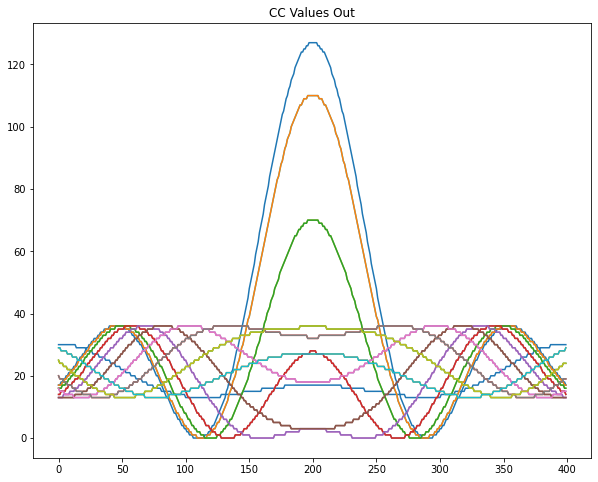

In [145]:
# Mapping the CC values is a little different time. We want each string to reflect its value against all other strings.
#  This means we need to set the interpolation for the cc values to go from the lowest point on any slice to the highest of any slice

target_n = 400 #All points
step = int(datalen/target_n)

cc_data = []
#for zsclice, slice by steps and add that to an array called note data
for i in range(0, datalen, 20):
    data = zslice[i] 
    ndata = data[0::step]
    cc_data.append(ndata)
    
print('Number of slices:', len(cc_data))
print('Length of an anyslice:', len(cc_data[0]))
print('Max/Min of All Data:', np.max(cc_data), np.min(cc_data))

cc_space = np.linspace(0,127,128)
cout = np.interp(cc_data, (np.min(cc_data), np.max(cc_data)), (0, len(cc_space)-1))
print(len(cout))
out = np.zeros((len(cout), len(cout[0]))) #Set official out array, index:ccvalue

for i in range(len(cout)):
    for j in range(len(cout[0])):
        s = int(np.round(cout[i][j]))
        out[i,j] = cc_space[s]
        
# The out array is a little different here, it's the size of the array of slices. We then perform the same rounding and mapping as before.
    
fig, ax = plt.subplots(1, figsize=(10,8))
for i in range(len(out)):
    ax.plot(out[i])
    
ax.set_title('CC Values Out')

Text(0.5, 1.0, 'CC Values with a function')

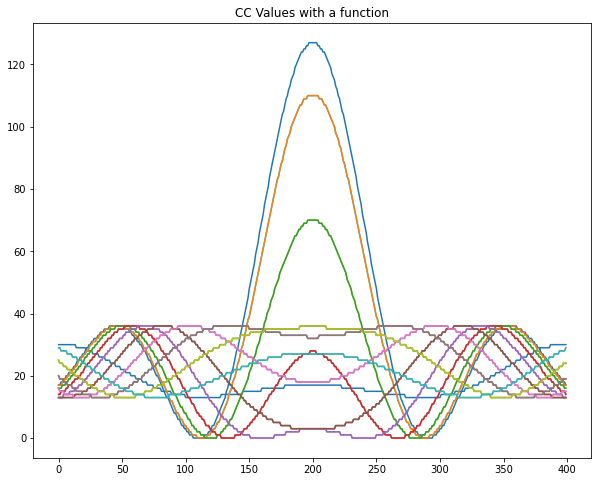

In [146]:
# Here's a function that does exactly what we just did.

def cc_values_from_array(data_array, target_n, slice_n):
    
    datalen = len(data_array[0])
    
    slicestep = int(len(data_array)/slice_n)
    step = int(datalen/target_n)
    
    cc_space = np.linspace(0,127,128)
    
    cc_data = []
    for i in range(0, datalen, slicestep):
        data = data_array[i] 
        cdata = data[0::step]
        cc_data.append(cdata)
    
    
    cout = np.interp(cc_data, (np.min(cc_data), np.max(cc_data)), (0, len(cc_space)-1))
    out = np.zeros((len(cout), len(cout[0]))) #Set official out array, index:midi

    for i in range(len(cout)):
        for j in range(len(cout[0])):
            s = int(np.round(cout[i][j]))
            out[i,j] = cc_space[s]
    
    return out

target_n = 400 #All Points
cc_values = cc_values_from_array(zslice, target_n, 20) #Using our new function

fig, ax = plt.subplots(1, figsize=(10,8))
for i in range(len(cc_values)):
    ax.plot(cc_values[i])
    
ax.set_title('CC Values with a function')

In [147]:
# Let's write the file. We will need 20 seperate midifiles because each will have their own CC data mapped to it.
#. Notice since these are seperate one note files we dont use the midichord function

#calculations for note length (one long note) Using the NOTE DATA
bpm = 120
spb = 1/(120/60.)

tscore_target = 30 #30 seconds long
div = tscore_target / 1
note_duration = int((960*div)/spb) #What we Want to know
print('Note duration in Ticks:', note_duration)

total_ticks = (note_duration * 1)
actual_scoretime = (total_ticks/960)*spb
print('Actual Score Time (sec): ', actual_scoretime)


midifiles = [] #list for the files
for i in range(len(midi_notes[1])):
    note = []
    note.append(midi_notes[1][i]) #the midimakefile expects an array not an into so we convert it to one
    
    midifile = alt_basic_diatonic_midifile(bpm, note_duration, note)
    midifiles.append(midifile)
    
print(midifiles[0:1])

Note duration in Ticks: 57600
Actual Score Time (sec):  30.0
File Length: 30.0 seconds
File Length: 30.0 seconds
File Length: 30.0 seconds
File Length: 30.0 seconds
File Length: 30.0 seconds
File Length: 30.0 seconds
File Length: 30.0 seconds
File Length: 30.0 seconds
File Length: 30.0 seconds
File Length: 30.0 seconds
File Length: 30.0 seconds
File Length: 30.0 seconds
File Length: 30.0 seconds
File Length: 30.0 seconds
File Length: 30.0 seconds
File Length: 30.0 seconds
File Length: 30.0 seconds
File Length: 30.0 seconds
File Length: 30.0 seconds
File Length: 30.0 seconds


In [148]:
# Let's write the CC data to each of these midi files

div = actual_scoretime / len(cc_values[0]) #seconds per data point
CCpoint_duration = int(np.round((960*div)/spb)) #What we Want to know
print('CC point Duration in Ticks:', CCpoint_duration)

for i in range(len(midifiles)):
    midifile = alt_make_cc_midifile(midifiles[i], CCpoint_duration, cc_values[i], channel_num=2)
    outfile_name = 'line_{}'.format(i+1)
    
    with open("MidiFiles/BigBadSurfaceMidi/{}.mid".format(outfile_name), "wb") as output_file:
        midifile.writeFile(output_file)

CC point Duration in Ticks: 144
